# Zindi Image classification (Binary)

In [46]:
# Import packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as img # to read images

import os                      # to generate new file directories
import shutil                  # to move files
from tqdm import tqdm          # to see process bar
import argparse


import glob                    # to gather jpg files
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tensorflow_datasets as tfds

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Use GPU:0

In [31]:
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    return strategy

In [32]:
strategy = auto_select_accelerator()
REPLICAS = strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE

Running on 1 replicas


# Input your own file directory

In [25]:
# Input your file directory

file_dir = 'D:/thon/DL/zindi' # Change here with your file directory

img_dir = file_dir + '/Images'

train_dir = img_dir + '/train'
test_dir = img_dir + '/test'

train1_dir = train_dir + '/1'
train0_dir = train_dir + '/0'

In [26]:
# Read train, test and submission csv files

train_df = pd.read_csv(file_dir + '/Train.csv')
test_df = pd.read_csv(file_dir + '/Test.csv')
sample_sub = pd.read_csv(file_dir + '/SampleSubmission.csv')

print(len(train_df['Image_id']))
print(train_df.head())
print('\n')
print(test_df.head())
print('\n')
print(len(test_df['Image_id']))
print(np.sum(test_df['Image_id'] == sample_sub['Image_id'])) # Test.csv and SampleSubmission.csv's Image_id is identical

1619
               Image_id  Label
0  id_02amazy34fgh2.jpg      1
1  id_02mh3w48pmyc9.jpg      0
2  id_02rpb463h9d3w.jpg      0
3  id_02wc3jeeao8ol.jpg      1
4  id_03t2hapb8wz8p.jpg      1


               Image_id
0  id_00exusbkgzw1b.jpg
1  id_03dqinf6w0znv.jpg
2  id_046yl0cxn3ybz.jpg
3  id_04athdtx2abyg.jpg
4  id_062aauf9e9jk0.jpg


1080
1080


# Image preprocessing

In [28]:
### Image preprocessing
# Set batch_size, img_height, img_width

batch_size = 64
img_size = 224 # EfficientNetB0 uses input shape (224, 224, 3)
channels = 3
size = (img_size, img_size)

# Train image dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split = 0.2, # 1619 * 0.8 = 1296 images are for train dataset
    label_mode = 'binary',
    subset = 'training',
    shuffle = True,
    seed = 2021120087,
    image_size = size,
    batch_size = batch_size)

print('\n')

# Validation image dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split = 0.2, # 1619 * 0.2 = 323 images are for validation dataset
    label_mode = 'binary',
    subset = "validation",
    shuffle = True,
    seed = 2021120087,
    image_size = size,
    batch_size = batch_size)

print('\n')

# Test image dataset

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = None,
    shuffle = False,
    image_size = size,
    batch_size = batch_size)

print('\n')

# Check the train image shapes

class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

print('\n')

for image_batch, labels_batch in train_ds:
    print("The shape of image is", image_batch.shape)
    print("The shape of labels is", labels_batch.shape)
    break

Found 1619 files belonging to 2 classes.
Using 1296 files for training.


Found 1619 files belonging to 2 classes.
Using 323 files for validation.


Found 1080 files belonging to 1 classes.


['0', '1']


The shape of image is (64, 224, 224, 3)
The shape of labels is (64, 1)


In [172]:
train_ds_unbatch = train_ds.unbatch()
train_ds_label = list(train_ds_unbatch.map(lambda x, y: y))
train_ds_img = list(train_ds_unbatch.map(lambda x, y: x))

val_ds_unbatch = val_ds.unbatch()
val_ds_label = list(val_ds_unbatch.map(lambda x, y: y))
val_ds_img = list(val_ds_unbatch.map(lambda x, y: x))

train_ds_one_hot_label = to_categorical(train_ds_label)
val_ds_one_hot_label = to_categorical(val_ds_label)

train_ds = tf.data.Dataset.from_tensor_slices({"img" : train_ds_img, "label" : train_ds_one_hot_label})
val_ds = tf.data.Dataset.from_tensor_slices({"img" : val_ds_img, "label" : val_ds_one_hot_label})

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [7]:
from tensorflow.keras.utils import to_categorical

train_ds_unbatch = train_ds.unbatch()
train_ds_label = list(train_ds_unbatch.map(lambda x, y: y))
train_ds_img = list(train_ds_unbatch.map(lambda x, y: x))

val_ds_unbatch = val_ds.unbatch()
val_ds_label = list(val_ds_unbatch.map(lambda x, y: y))
val_ds_img = list(val_ds_unbatch.map(lambda x, y: x))

train_ds_one_hot_label = to_categorical(train_ds_label)
val_ds_one_hot_label = to_categorical(val_ds_label)

train_ds = tf.data.Dataset.from_tensor_slices((train_ds_img, train_ds_one_hot_label))
val_ds = tf.data.Dataset.from_tensor_slices((val_ds_img, val_ds_one_hot_label))

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [41]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

AttributeError: module 'tensorflow.keras.layers' has no attribute 'RandomRotation'

# Define Model using tensorflow

In [29]:
# ConvNet layers

inputs = keras.Input(shape = (img_size, img_size, channels))
x = tf.keras.applications.EfficientNetB0(weights = None, classes = num_classes)(inputs)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(
    optimizer = 'adam',
    loss = tf.losses.BinaryCrossentropy(),
    metrics = ['Accuracy']
)


# Model summary

model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 2)                 4052133   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 3         
Total params: 4,052,136
Trainable params: 4,010,113
Non-trainable params: 42,023
_________________________________________________________________


# Train model

In [39]:
# Train model

history = model.fit(train_ds, validation_data = val_ds, epochs = 20, batch_size = batch_size)

Epoch 1/20


ResourceExhaustedError:  OOM when allocating tensor with shape[40,144,1,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_7/efficientnetb0/block3a_project_conv/Conv2D (defined at \AppData\Local\Temp\ipykernel_14908\890731201.py:3) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_124106]

Function call stack:
train_function


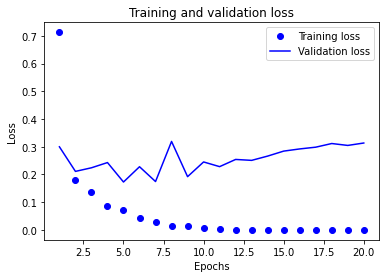

In [42]:
# Visualize validation loss and accuracy loss

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label = "Training loss")
plt.plot(epochs, val_loss_values, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# To find the best model

In [45]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convnet.keras", # Save the best model as 'convnet.kears'
        save_best_only = True,
        monitor = "val_loss")
]

history_test = model.fit(
    train_ds,
    epochs = 50,
    validation_data = val_ds,
    callbacks = callbacks)

Epoch 1/50
41/41 [==============================] - 5s 95ms/step - loss: 0.6567 - auc: 0.6537 - val_loss: 0.6228 - val_auc: 0.8502
Epoch 2/50
41/41 [==============================] - 4s 91ms/step - loss: 0.5060 - auc: 0.8363 - val_loss: 0.4167 - val_auc: 0.8943
Epoch 3/50
41/41 [==============================] - 4s 91ms/step - loss: 0.4145 - auc: 0.8975 - val_loss: 0.3216 - val_auc: 0.9382
Epoch 4/50
41/41 [==============================] - 4s 92ms/step - loss: 0.2874 - auc: 0.9493 - val_loss: 0.2627 - val_auc: 0.9662
Epoch 5/50
41/41 [==============================] - 4s 91ms/step - loss: 0.2172 - auc: 0.9709 - val_loss: 0.2686 - val_auc: 0.9531
Epoch 6/50
41/41 [==============================] - 4s 90ms/step - loss: 0.1767 - auc: 0.9805 - val_loss: 0.1984 - val_auc: 0.9843
Epoch 7/50
41/41 [==============================] - 4s 91ms/step - loss: 0.1405 - auc: 0.9871 - val_loss: 0.1855 - val_auc: 0.9794
Epoch 8/50
41/41 [==============================] - 4s 91ms/step - loss: 0.1104 - a

In [46]:
# Fit the best model

test_model = keras.models.load_model("convnet.keras") # load the best model which we defined "convnet.keras"

predictions = test_model.predict(test_ds)
prediction_classes = [
    1 if prob > 0.5 else 0 for prob in np.ravel(predictions)
]

sample_sub["Label"] = prediction_classes
sample_sub.head()

,Image_id,Label
0,id_00exusbkgzw1b.jpg,0
1,id_03dqinf6w0znv.jpg,0
2,id_046yl0cxn3ybz.jpg,1
3,id_04athdtx2abyg.jpg,0
4,id_062aauf9e9jk0.jpg,0


In [47]:
# Save csv file

sample_sub.to_csv("Submission.csv", index = False)